<a href="https://colab.research.google.com/github/DelightAzuogu/OCR-project/blob/master/English_characters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
dhruvildave_english_handwritten_characters_dataset_path = kagglehub.dataset_download('dhruvildave/english-handwritten-characters-dataset')

print('Data source import complete.')


Data source import complete.


In [8]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [9]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input , Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D
import cv2 as cv
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.optimizers import Adam
from sklearn.utils import shuffle

import matplotlib.pyplot as plt

In [10]:
test_data = '/content/english (1).csv'
df = pd.read_csv(test_data)

In [11]:
df["label"].value_counts()


,count
label,
0,55
1,55
2,55
3,55
4,55
...,...
v,55
w,55
x,55


In [ ]:
# labels = df_test_data['label'].tolist()
# labels

In [12]:
images_path = '/kaggle/input/english-handwritten-characters-dataset/Img'

# List to hold the dimensions of all images
image_sizes = []

for image_file in os.listdir(images_path):
    image_path = os.path.join(images_path, image_file)
    image = cv.imread(image_path)
    if image is not None:
        height, width = image.shape[:2]
        image_sizes.append((width, height))

# Print the size of the first image
if image_sizes:
    print("Size of the first image:", image_sizes[1])
    print("Unique image sizes:", set(image_sizes))
else:
    print("No images found in the directory.")

Size of the first image: (1200, 900)
Unique image sizes: {(1200, 900)}


In [13]:
images_path = '/kaggle/input/english-handwritten-characters-dataset/Img'
images = []
labels = []

for image_file in os.listdir(images_path):
    image_path = os.path.join(images_path, image_file)
    image = cv.imread(image_path).astype('float32')
    image = cv.resize(image, (64, 64))
    image = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
    #image = cv.GaussianBlur(image, (1, 1), 0)
    image /= 255.0
    label_index = os.path.join("Img", image_file)
    label = df[df['image'] == label_index].label.values[0]
    images.append(image)
    labels.append(label)

images = np.array(images)
labels = np.array(labels)


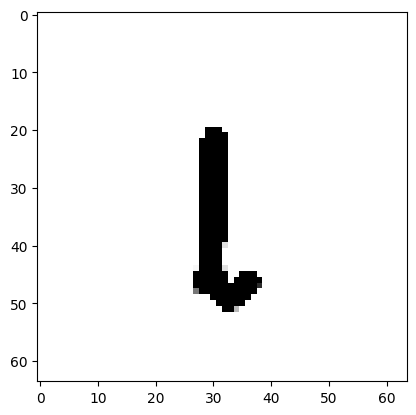

In [14]:
plt.gray()
plt.imshow(images[100])

In [15]:
print("Number of images:", len(images))
print("Shape of each image:", images.shape[1:])
print("Unique labels:", np.unique(labels))

Number of images: 3410
Shape of each image: (64, 64)
Unique labels: ['0' '1' '2' '3' '4' '5' '6' '7' '8' '9' 'A' 'B' 'C' 'D' 'E' 'F' 'G' 'H'
 'I' 'J' 'K' 'L' 'M' 'N' 'O' 'P' 'Q' 'R' 'S' 'T' 'U' 'V' 'W' 'X' 'Y' 'Z'
 'a' 'b' 'c' 'd' 'e' 'f' 'g' 'h' 'i' 'j' 'k' 'l' 'm' 'n' 'o' 'p' 'q' 'r'
 's' 't' 'u' 'v' 'w' 'x' 'y' 'z']


In [16]:
# One hot encode the labels

encoder = OneHotEncoder(sparse_output=False)
labels = encoder.fit_transform(labels.reshape(-1, 1))


In [17]:
decoder = [str(i) for i in range(10)] + [chr(i) for i in range(65, 91)] + [chr(i) for i in range(97, 123)]


In [18]:
images, labels = shuffle(images, labels, random_state=0)


In [19]:
from tensorflow.keras.callbacks import LearningRateScheduler
import numpy as np

# Define an exponential decay learning rate schedule function
def exponential_decay(epoch, lr):
    initial_lr = 0.001
    k = 0.1
    decay_rate = k ** (epoch / 10)
    return initial_lr * decay_rate

In [20]:
X_train, X_temp, Y_train, Y_temp = train_test_split(images, labels, test_size=0.3, random_state=0)
X_val, X_test, Y_val, Y_test = train_test_split(X_temp, Y_temp, test_size=0.5, random_state=0)

In [21]:
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

In [49]:
# Initialize lists to hold augmented images and labels
augmented_arr_X = []
augmented_arr_Y = []
number_of_augmentation = 5

# Iterate over each image in X_train
for i in range(len(X_train)):
    # Ensure the image has the correct shape (height, width, channels)
    image = X_train[i]
    if image.ndim == 2:
        image = np.expand_dims(image, axis=-1)  # Convert (height, width) to (height, width, channels)

    # Expand dimensions to include batch size
    image_expanded = np.expand_dims(image, axis=0)  # Shape: (1, height, width, channels)

    # Create iterator for augmented images
    aug_iter = datagen.flow(image_expanded, batch_size=1)

    # Generate augmented images
    augmented_images = [next(aug_iter)[0] for _ in range(number_of_augmentation)]

    # Extend the list with the new augmented images and corresponding labels
    augmented_arr_X.extend(augmented_images)
    augmented_arr_Y.extend([Y_train[i]] * number_of_augmentation)

# Convert lists to numpy arrays
augmented_arr_X = np.array(augmented_arr_X)
augmented_arr_Y = np.array(augmented_arr_Y)

print("Augmented images shape:", augmented_arr_X.shape)
print("Augmented labels shape:", augmented_arr_Y.shape)

Augmented images shape: (59675, 64, 64, 1)
Augmented labels shape: (59675, 62)


In [23]:
X_train = np.array(augmented_arr_X)
Y_train = np.array(augmented_arr_Y)

In [47]:
X_train, Y_train = shuffle(X_train, Y_train, random_state=0)


TypeError: Invalid shape (1, 60, 40, 1) for image data

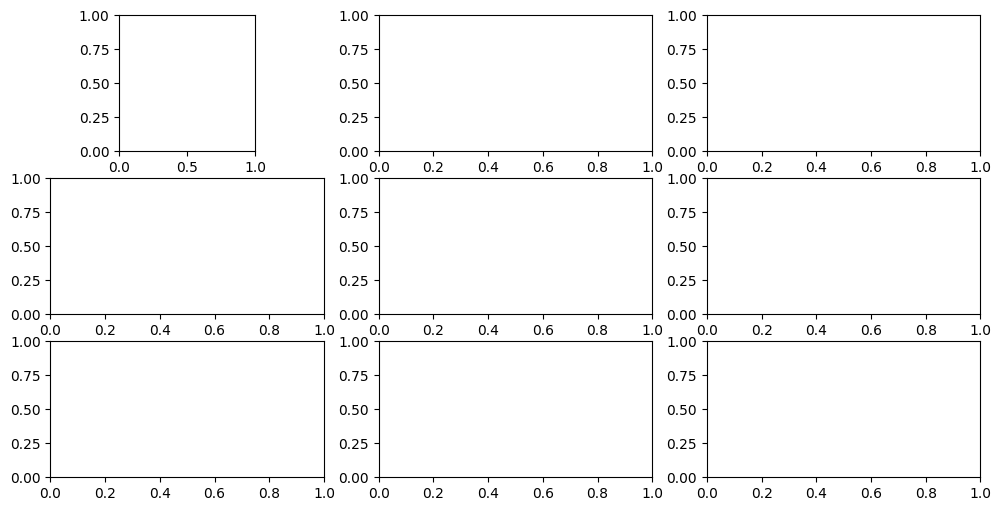

In [50]:
# Plot 9 random images for visualisation

def display_images(rows, cols, images, labels, decoder):
    _, axes = plt.subplots(nrows = 3, ncols = 3, figsize=(12,6))

    for i, ax in enumerate(axes.flatten()):
        ax.imshow(images[i], cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(f"Label: {decoder[np.where(labels[i]==1)[0][0]]}")

display_images(3, 3, images, labels, decoder)

In [26]:
num_classes = len(np.unique(labels))  # Check how many unique labels you have
print("Number of classes:", num_classes)


Number of classes: 2


In [27]:
# Define model

model = Sequential([
    Input(shape=(64, 64, 1)),

    Conv2D(512, (5, 5), activation='relu'),

    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Conv2D(256, (3, 3), activation='relu'),
    MaxPooling2D(pool_size=(2, 2)),

    Flatten(),

    Dense(512, activation='relu'),
    Dropout(0.1),

    Dense(1024, activation='relu'),

    Dense(512, activation='relu'),
    Dropout(0.1),

    Dense(256, activation='sigmoid'),

    Dense(62, activation='softmax')
])

In [ ]:
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 60, 60, 512)    │        13,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 30, 30, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 28, 28, 256)    │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 14, 14, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 12, 12, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 6, 6, 256)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 512)            │     4,719,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1024)           │       525,312 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 62)             │        15,934 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,699,774 (29.37 MB)

 Trainable params: 7,699,774 (29.37 MB)

 Non-trainable params: 0 (0.00 B)

In [28]:
print("Shape of X_train:", X_train.shape)
print("Shape of X_val:", X_val.shape)
print("Shape of X_test:", X_test.shape)


Shape of X_train: (11935, 64, 64, 1)
Shape of X_val: (511, 64, 64)
Shape of X_test: (512, 64, 64)


In [29]:
import tensorflow as tf

from tensorflow.keras.mixed_precision import global_policy, set_global_policy, Policy

# Create a mixed precision policy
policy = Policy('mixed_float16')
set_global_policy(policy)

def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))


lr_scheduler = LearningRateScheduler(scheduler)

# Define early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# Compile the model
model.compile(optimizer=Adam(learning_rate=1e-4),  # Use a lower learning rate for stability
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Train the model with the callbacks
history = model.fit(
    X_train, Y_train,
    epochs=5,
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[lr_scheduler, early_stopping]  # Add both callbacks here
)


Epoch 1/5
373/373 ━━━━━━━━━━━━━━━━━━━━ 39s 73ms/step - accuracy: 0.0157 - loss: 4.1854 - val_accuracy: 0.0352 - val_loss: 4.0151 - learning_rate: 1.0000e-04
Epoch 2/5
373/373 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.0764 - loss: 3.7047 - val_accuracy: 0.2329 - val_loss: 2.9184 - learning_rate: 1.0000e-04
Epoch 3/5
373/373 ━━━━━━━━━━━━━━━━━━━━ 20s 42ms/step - accuracy: 0.1852 - loss: 3.0221 - val_accuracy: 0.3659 - val_loss: 2.3372 - learning_rate: 1.0000e-04
Epoch 4/5
373/373 ━━━━━━━━━━━━━━━━━━━━ 21s 42ms/step - accuracy: 0.3378 - loss: 2.4775 - val_accuracy: 0.5205 - val_loss: 1.8379 - learning_rate: 9.0484e-05
Epoch 5/5
373/373 ━━━━━━━━━━━━━━━━━━━━ 16s 42ms/step - accuracy: 0.4676 - loss: 2.0430 - val_accuracy: 0.5812 - val_loss: 1.5214 - learning_rate: 8.1873e-05


In [31]:
model.save('final_model.h5')


In [ ]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras.mixed_precision import Policy, set_global_policy

# === Set Mixed Precision Policy ===
policy = Policy('mixed_float16')
set_global_policy(policy)

# === Load the Model ===
model = load_model('/content/final_model.h5')

# === Learning Rate Scheduler ===
def scheduler(epoch, lr):
    if epoch < 3:
        return lr
    else:
        return float(lr * tf.math.exp(-0.1))

lr_scheduler = LearningRateScheduler(scheduler)

# === Early Stopping Callback ===
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

# === Compile the Model ===
# Explicitly re-define the optimizer because the state isn't loaded.
model.compile(
    optimizer=Adam(learning_rate=1e-4),  # Ensure you're using the same optimizer configuration
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# === Continue Training ===
history = model.fit(
    X_train, Y_train,
    epochs=30,  # Updated to 20
    batch_size=32,
    validation_data=(X_val, Y_val),
    callbacks=[lr_scheduler, early_stopping]
)


Epoch 1/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 25s 50ms/step - accuracy: 0.5634 - loss: 1.7003 - val_accuracy: 0.6595 - val_loss: 1.2657 - learning_rate: 1.0000e-04
Epoch 2/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 15s 39ms/step - accuracy: 0.6266 - loss: 1.3910 - val_accuracy: 0.6791 - val_loss: 1.0750 - learning_rate: 1.0000e-04
Epoch 3/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.6980 - loss: 1.1442 - val_accuracy: 0.7104 - val_loss: 0.9352 - learning_rate: 1.0000e-04
Epoch 4/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.7346 - loss: 0.9706 - val_accuracy: 0.7299 - val_loss: 0.8456 - learning_rate: 9.0484e-05
Epoch 5/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/step - accuracy: 0.7740 - loss: 0.8191 - val_accuracy: 0.7358 - val_loss: 0.7885 - learning_rate: 8.1873e-05
Epoch 6/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 20s 40ms/step - accuracy: 0.8025 - loss: 0.7189 - val_accuracy: 0.7789 - val_loss: 0.6941 - learning_rate: 7.4082e-05
Epoch 7/30
373/373 ━━━━━━━━━━━━━━━━━━━━ 15s 40ms/ste

In [56]:
import tensorflow as tf
import numpy as np
import cv2
import os

# Load the trained model
model = tf.keras.models.load_model('/content/final_model.h5')  # replace with your model's file path

# Define the image path for prediction
image_path = "/content/jay.png"

# Load the image (ensure it's grayscale, as expected by the model)
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Resize the image to 64x64 (this matches the training preprocessing)
image = cv2.resize(image, (64, 64))

# Normalize the image to the range [0, 1]
image = image.astype("float32") / 255.0

# Add a batch dimension (making it shape (1, 64, 64, 1))
image = np.expand_dims(image, axis=-1)  # shape becomes (64, 64, 1)
image = np.expand_dims(image, axis=0)   # shape becomes (1, 64, 64, 1)

# Make the prediction
predictions = model.predict(image)

# Get the predicted class (for classification models)
predicted_class = np.argmax(predictions, axis=-1)

print(f"Predicted class: {predicted_class}")


Exception ignored in: <function _xla_gc_callback at 0x7a2627cce5c0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/jax/_src/lib/__init__.py", line 96, in _xla_gc_callback
    def _xla_gc_callback(*args):
    
KeyboardInterrupt: 


1/1 ━━━━━━━━━━━━━━━━━━━━ 149s 149s/step
Predicted class: [19]


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step


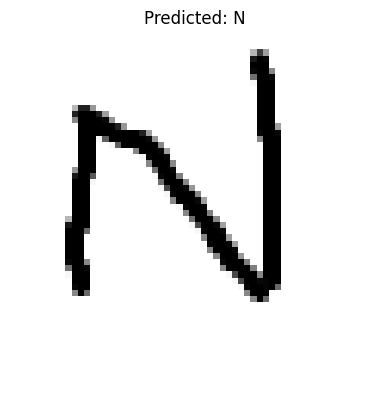

Predicted class: N


In [70]:
import tensorflow as tf
import numpy as np
import cv2
import matplotlib.pyplot as plt

# Define the class labels
class_labels = [
    '0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H',
    'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z',
    'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r',
    's', 't', 'u', 'v', 'w', 'x', 'y', 'z'
]

# Load the trained model
model = tf.keras.models.load_model('/content/final_model.h5')  # replace with your model's file path

# Define the image path for prediction
image_path = "/content/N.png"

# Load the image (ensure it's grayscale, as expected by the model)
image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)

# Resize the image to 64x64 (this matches the training preprocessing)
image_resized = cv2.resize(image, (64, 64))

# Normalize the image to the range [0, 1]
image_resized = image_resized.astype("float32") / 255.0

# Add a batch dimension (making it shape (1, 64, 64, 1))
image_resized = np.expand_dims(image_resized, axis=-1)  # shape becomes (64, 64, 1)
image_resized = np.expand_dims(image_resized, axis=0)   # shape becomes (1, 64, 64, 1)

# Make the prediction
predictions = model.predict(image_resized)

# Get the predicted index (for classification models)
predicted_index = np.argmax(predictions, axis=-1)

# Get the predicted class label
predicted_label = class_labels[predicted_index[0]]

# Display the image and predicted label
plt.imshow(image, cmap='gray')  # Show the original image
plt.title(f"Predicted: {predicted_label}")  # Display the predicted label as the title
plt.axis('off')  # Hide axes for a cleaner image display
plt.show()

print(f"Predicted class: {predicted_label}")
